# Test Your Algorithm

## Instructions
1. From the **Pulse Rate Algorithm** Notebook you can do one of the following:
   - Copy over all the **Code** section to the following Code block.
   - Download as a Python (`.py`) and copy the code to the following Code block.
2. In the bottom right, click the <span style="color:blue">Test Run</span> button. 

### Didn't Pass
If your code didn't pass the test, go back to the previous Concept or to your local setup and continue iterating on your algorithm and try to bring your training error down before testing again.

### Pass
If your code passes the test, complete the following! You **must** include a screenshot of your code and the Test being **Passed**. Here is what the starter filler code looks like when the test is run and should be similar. A passed test will include in the notebook a green outline plus a box with **Test passed:** and in the Results bar at the bottom the progress bar will be at 100% plus a checkmark with **All cells passed**.
![Example](example.png)

1. Take a screenshot of your code passing the test, make sure it is in the format `.png`. If not a `.png` image, you will have to edit the Markdown render the image after Step 3. Here is an example of what the `passed.png` would look like 
2. Upload the screenshot to the same folder or directory as this jupyter notebook.
3. Rename the screenshot to `passed.png` and it should show up below.
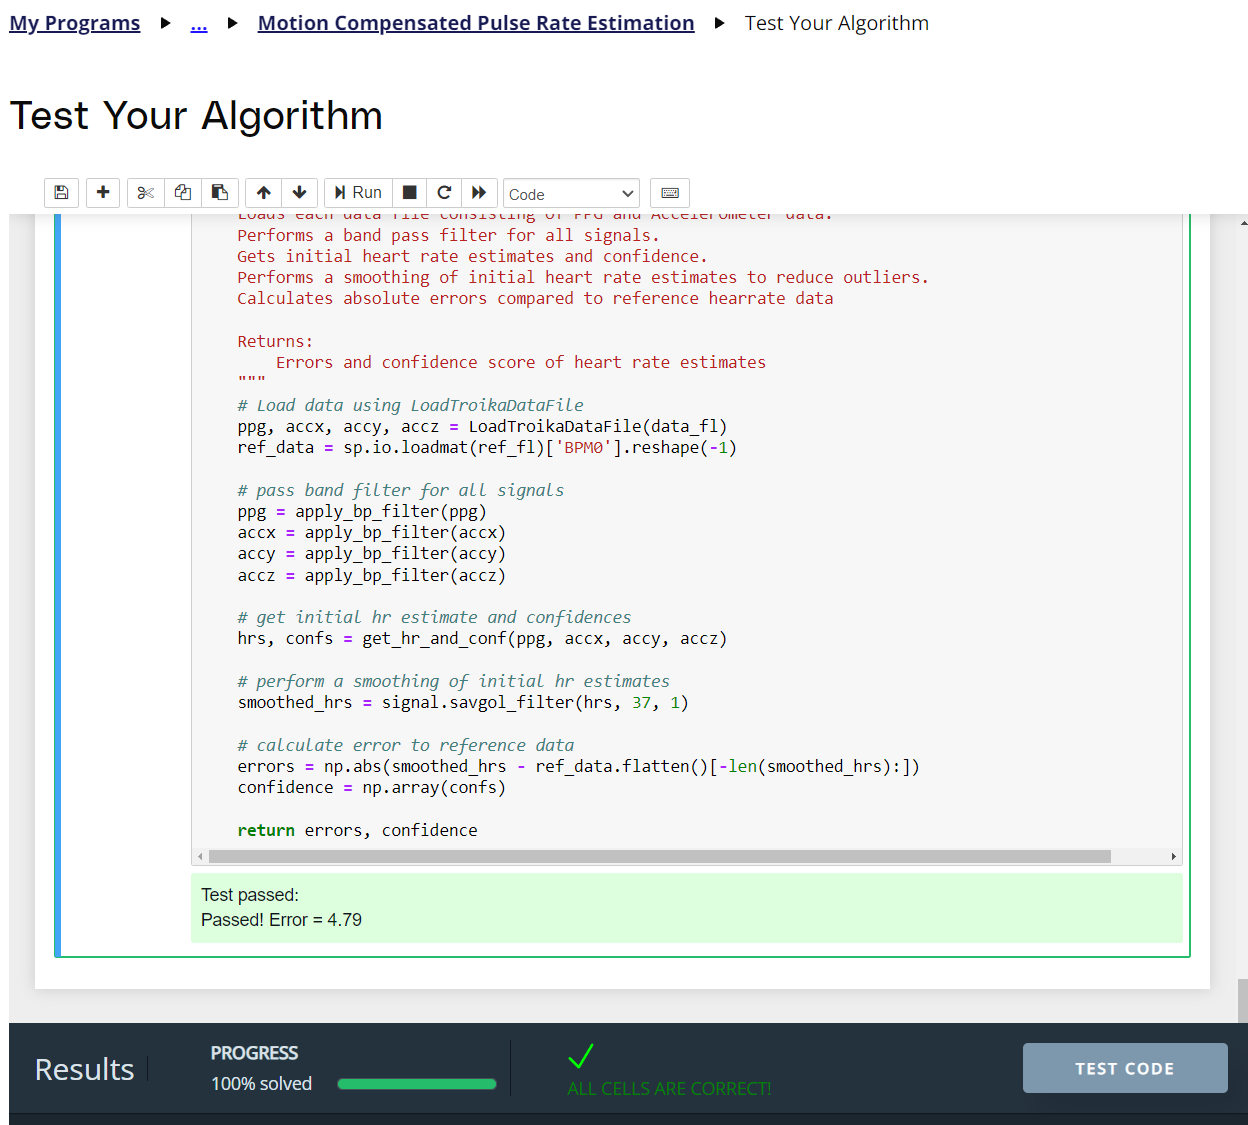
4. Download this jupyter notebook as a `.pdf` file. 
5. Continue to Part 2 of the Project. 

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
plt.ioff()

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def apply_bp_filter(sig, fs=125, low_cutoff=40, high_cutoff=240):
    """
    Bandpass filter function

    Performs a bandpass filter using the provided cutoff thresholds

    Returns:
        A filtered signal
    """
    b, a = signal.butter(3, [low_cutoff/60, high_cutoff/60], btype='bandpass', fs=fs)
    filt_sig = signal.filtfilt(b, a, sig)
    return filt_sig

def get_specgram_results(signal, fs=125, low_cutoff=40, high_cutoff=240):
    """
    Specgram calculation function

    Uses matplotlibs specgram function to calculate a FT specgram.
    Filters the results to the provided cutoff thresholds.

    Returns:
        Filtered specgram frequencies and frequency magnitudes
    """
    signal_spec, signal_freqs, _, _ = plt.specgram(signal, NFFT=fs*12, Fs=fs, noverlap=fs*10)
    freq_filter = (signal_freqs >= low_cutoff/60) & (signal_freqs < high_cutoff/60)
    filtered_signal_freqs = signal_freqs[freq_filter]
    filtered_signal_spec = signal_spec[freq_filter]
    
    return filtered_signal_freqs, filtered_signal_spec

def get_hr_and_conf(ppg, accx, accy, accz, fs=125):
    """
    Heartrate estimator and confidence function

    Calculates an initial estimate of heart rate based on the PPG dominant frequency.
    Performs refinement to PPG dominant frequency via comparison to accelerometer dominant frequencies.
    Calculates a confidence score as the intensity of the PPG dominant frequency vs. total signal intensity.

    Returns:
        Initial heart rate estimates and confidence scores
    """
    # get specgram results for all signals
    filtered_ppg_freqs, filtered_ppg_spec = get_specgram_results(ppg)
    filtered_accx_freqs, filtered_accx_spec = get_specgram_results(accx)
    filtered_accy_freqs, filtered_accy_spec = get_specgram_results(accy)
    filtered_accz_freqs, filtered_accz_spec = get_specgram_results(accz)

    hrs = []
    confs = []
    for i in range(filtered_ppg_spec.shape[1]):
        # for each windowed chunk of frequency magnitudes
        ppg_chunk = filtered_ppg_spec[:, i]
        accx_chunk = filtered_accx_spec[:, i]
        accy_chunk = filtered_accy_spec[:, i]
        accz_chunk = filtered_accz_spec[:, i]

        # we select an initial dominant frequency for each modality
        dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]
        dom_accx = filtered_accx_freqs[accx_chunk.argmax()]
        dom_accy = filtered_accy_freqs[accy_chunk.argmax()]
        dom_accz = filtered_accz_freqs[accz_chunk.argmax()]

        # compare initial dominant PPG frequency to accelerometer dominant freqs and make adjustments
        while np.isclose(dom_ppg, dom_accx, atol=0.1):
            ppg_chunk[ppg_chunk.argmax()] = 0
            dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]

        while np.isclose(dom_ppg, dom_accy, atol=0.1):
            ppg_chunk[ppg_chunk.argmax()] = 0
            dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]

        while np.isclose(dom_ppg, dom_accz, atol=0.1):
            ppg_chunk[ppg_chunk.argmax()] = 0
            dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]

        # best estimate of heart rate with acc freqs removed
        hrs.append(dom_ppg * 60)

        # calculate a confidence as the proportion of intensity of the dominate PPG freq
        conf = ppg_chunk[ppg_chunk.argmax()] / ppg_chunk.sum()
        confs.append(conf)
        
    return hrs, confs


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Entry point of algorithm
    
    Loads each data file consisting of PPG and Accelerometer data.
    Performs a band pass filter for all signals.
    Gets initial heart rate estimates and confidence.
    Performs a smoothing of initial heart rate estimates to reduce outliers.
    Calculates absolute errors compared to reference hearrate data

    Returns:
        Errors and confidence score of heart rate estimates
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_data = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)

    # pass band filter for all signals
    ppg = apply_bp_filter(ppg)
    accx = apply_bp_filter(accx)
    accy = apply_bp_filter(accy)
    accz = apply_bp_filter(accz)

    # get initial hr estimate and confidences
    hrs, confs = get_hr_and_conf(ppg, accx, accy, accz)

    # perform a smoothing of initial hr estimates
    smoothed_hrs = signal.savgol_filter(hrs, 37, 1)
    
    # calculate error to reference data
    errors = np.abs(smoothed_hrs - ref_data.flatten()[-len(smoothed_hrs):])
    confidence = np.array(confs)

    return errors, confidence